<a href="https://colab.research.google.com/github/maddogmikeb/Jira/blob/master/UltimateSprintReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [330]:
from IPython.core.display import clear_output

#sprint_report_url = input("Please enter the 'classic Jira sprint report' url:")

sprint_report_url = "https://brisbanecitycouncil.atlassian.net/jira/software/c/projects/FDSEWMSR/boards/364/reports/sprint-retrospective?sprint=944"
clear_output()

In [331]:
# install dependencies

from IPython.core.display import clear_output

!pip install -q atlassian-python-api
!pip install -q matplotlib
!pip install -q numpy

clear_output()

# Go to [Report](#scrollTo=LHsrbWEt6_Ik)

In [332]:
# Configure display

from IPython.core.display import clear_output
from google.colab import data_table
import json

data_table.enable_dataframe_formatter()

def printjson(obj):
  print(json.dumps(obj, indent=2))

clear_output()

In [333]:
# Log in

from IPython.core.display import display, HTML, clear_output
from atlassian import Jira
from google.colab import userdata
from urllib.parse import urlparse
import re

def parse_url(url):
    pattern = r"(https?)://([^/]+)/jira/software/c/projects/([^/]+)/boards/(\d+)/reports/sprint-retrospective\?sprint=(\d+)"
    match = re.search(pattern, url)
    if match:
        protocol = match.group(1)
        base_url = match.group(2)
        project = match.group(3)
        rapidViewId = match.group(4)
        sprintId = match.group(5)
        full_base_url = f"{protocol}://{base_url}"
        return full_base_url, project, rapidViewId, sprintId
    else:
        return None, None, None, None

base_url, project, rapidViewId, sprintId = parse_url(sprint_report_url)

jira = Jira(
  url=base_url,
  username=userdata.get('atlassian_username'),
  password=userdata.get('atlassian_apikey'),
  cloud=True
)

me = jira.myself()

clear_output()

In [334]:
status_categories = jira.get("/rest/api/2/statuscategory")

In [335]:
import json

sprint_report = json.loads(jira.request(absolute=True, method="GET", path="{base_url}{path}?rapidViewId={rapidViewId}&sprintId={sprintId}".format(base_url = base_url, path="/rest/greenhopper/latest/rapid/charts/sprintreport", rapidViewId=rapidViewId, sprintId=sprintId)).content)

In [336]:
import json

velocity_statistics = json.loads(jira.request(absolute=True, method="GET", path="{base_url}{path}?rapidViewId={rapidViewId}".format(base_url = base_url, path="/rest/greenhopper/1.0/rapid/charts/velocity.json", rapidViewId=rapidViewId)).content)

try:
  sprint_velocity_statistics = velocity_statistics['velocityStatEntries'][str(sprintId)]
except:
  sprint_velocity_statistics = None

In [337]:
import json

board_config = json.loads(jira.request(absolute=True, method="GET", path="{base_url}{path}?rapidViewId={rapidViewId}".format(base_url = base_url, path="/rest/greenhopper/1.0/rapidviewconfig/editmodel.json", rapidViewId=rapidViewId)).content)

In [338]:
from IPython.core.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

class DataPoint:
    def __init__(self, name, count, points, color, hatch, edge_color):
        self.name = name
        self.count = count
        self.points = points
        self.color = color
        self.hatch = hatch
        self.edge_color = edge_color

    def get_values(self):
        return [self.count, self.points]

def get_status_category_id(status_categories, name):
    return str(next(x['id'] for x in status_categories if x['name'] == name))

def calculate_estimates(sprint_report, status_category_id):
    count = 0
    estimate = 0
    for issue in sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]:
        if issue["status"]["statusCategory"]['id'] == status_category_id:
            count += 1
            estimate += issue['estimateStatistic']['statFieldValue'].get('value', 0)
    return count, estimate

TODO_KEY_ID = get_status_category_id(status_categories, 'To Do')
INPROGRESS_KEY_ID = get_status_category_id(status_categories, 'In Progress')

ToDoCount, ToDoEstimate = calculate_estimates(sprint_report, TODO_KEY_ID)
ProgressCount, ProgressEstimate = calculate_estimates(sprint_report, INPROGRESS_KEY_ID)

Removed = DataPoint(
    'Removed',
    -len(sprint_report["contents"]["puntedIssues"]),
    -sprint_report["contents"].get('puntedIssuesEstimateSum', {}).get('value', 0),
    '#d04437',
    None,
    '#ccc'
)

ToDo = DataPoint(
    'ToDo',
    ToDoCount,
    ToDoEstimate,
    '#091E420F',
    None,
    '#44546F'
)

InProgress = DataPoint(
    'InProgress',
    ProgressCount,
    ProgressEstimate,
    '#deebff',
    None,
    '#0055CC'
)

Done = DataPoint(
    'Completed',
    len(sprint_report["contents"]["completedIssues"]),
    sprint_report["contents"].get("completedIssuesEstimateSum", {}).get('value', 0),
    '#e3fcef',
    None,
    '#216E4E'
)

CompletedOutside = DataPoint(
    'Completed Outside',
    len(sprint_report["contents"]["issuesCompletedInAnotherSprint"]),
    sprint_report["contents"].get("issuesCompletedInAnotherSprintEstimateSum", {}).get('value', 0),
    '#e3fcef',
    'X',
    '#216E4E'
)

if sprint_velocity_statistics:
    TotalCommitted = [
        len(sprint_velocity_statistics["allConsideredIssueKeys"]),
        sprint_velocity_statistics["estimated"].get('value', 0)
    ]
else:
    TotalCommitted = [
        len(sprint_report["contents"]["completedIssues"]) +
        len(sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]) +
        len(sprint_report["contents"]["issuesCompletedInAnotherSprint"]) +
        len(sprint_report["contents"]["puntedIssues"]) -
        len(sprint_report["contents"]["issueKeysAddedDuringSprint"]),
        sum(
            float(sprint_report["contents"].get(key, {}).get('value', 0))
            for key in [
                "completedIssuesInitialEstimateSum",
                "issuesNotCompletedInitialEstimateSum",
                "puntedIssuesInitialEstimateSum",
                "issuesCompletedInAnotherSprintInitialEstimateSum"
            ]
        )
    ]


In [339]:
from IPython.core.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import base64
import io

def cumulate_data(data_array):
    data = np.array(data_array)
    data_shape = data.shape

    def get_cumulated_array(data, **kwargs):
        cum = np.cumsum(data.clip(**kwargs), axis=0)
        d = np.zeros_like(data)
        d[1:] = cum[:-1]
        return d

    cumulated_data = get_cumulated_array(data, min=0)
    cumulated_data_neg = get_cumulated_array(data, max=0)

    row_mask = data < 0
    cumulated_data[row_mask] = cumulated_data_neg[row_mask]
    data_stack = cumulated_data

    return data, data_shape, data_stack

def plot_data(values, col_labels, cols, edge_colors, hatch, total_committed):
    data, data_shape, data_stack = cumulate_data(values)

    _, ax = plt.subplots(figsize=(10, 10))

    for i in range(data_shape[0]):
        bars = ax.bar(np.arange(data_shape[1]), data[i], bottom=data_stack[i], color=cols[i], edgecolor=edge_colors[i], hatch=hatch[i], width=0.5)
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color='black', fontweight='bold')

    for i in range(len(total_committed)):
        ax.vlines(x=i-0.4, ymin=0, ymax=total_committed[i], color='#8590a2', linestyle='solid', linewidth=5)
        if total_committed[i] > 0:
            ax.text(i-0.4, total_committed[i] + 0.4, f'{str(total_committed[i]).rjust(3)}', color='black', horizontalalignment='center', fontweight='bold')

    ax.set_xticks(np.arange(data_shape[1]))
    ax.set_xticklabels(col_labels)

    ax.axhline(0, color='black', linewidth=0.8)

    legend_elements = [
        Line2D([0], [0], color='#8590a2', lw=2, label='Committed'),
        Patch(facecolor=ToDo.color, edgecolor=ToDo.edge_color, label=ToDo.name),
        Patch(facecolor=InProgress.color, edgecolor=InProgress.edge_color, label=InProgress.name),
        Patch(facecolor=Done.color, edgecolor=Done.edge_color, label=Done.name),
        Patch(facecolor=CompletedOutside.color, edgecolor=CompletedOutside.edge_color, hatch="X", label=CompletedOutside.name),
        Patch(facecolor=Removed.color, edgecolor=Removed.edge_color, label=Removed.name)
    ]

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', pad_inches=0.5)
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close()

    committed_vs_planned_chart = f'<img src="data:image/png;base64,{image_base64}" width="400px" height="400px" alt="Committed vs Planned"/>'
    return committed_vs_planned_chart

col_labels = ['Count', 'Points']
cols = [Removed.color, Done.color, CompletedOutside.color, InProgress.color, ToDo.color]
edge_colors = [Removed.edge_color, Done.edge_color, CompletedOutside.edge_color, InProgress.edge_color, ToDo.edge_color]
hatch = [Removed.hatch, Done.hatch, CompletedOutside.hatch, InProgress.hatch, ToDo.hatch]
values = [Removed.get_values(), Done.get_values(), CompletedOutside.get_values(), InProgress.get_values(), ToDo.get_values()]

committed_vs_planned_chart = plot_data(values, col_labels, cols, edge_colors, hatch, TotalCommitted)

clear_output(wait=True)

In [340]:
from IPython.core.display import clear_output
import numpy as np
from datetime import datetime

def calculate_sprint_details(sprint_report):
    start = datetime.strptime(sprint_report["sprint"]["isoStartDate"], "%Y-%m-%dT%H:%M:%S%z").date()
    end = datetime.strptime(sprint_report["sprint"]["isoEndDate"], "%Y-%m-%dT%H:%M:%S%z").date()
    weekmask = ' '.join([k.capitalize()[:3] for k,v in dict(board_config['workingDaysConfig']['weekDays']).items() if v == True])
    holidays = [datetime.strptime(date, "%Y-%m-%d").date() for date in [x['iso8601Date'] for x in board_config['workingDaysConfig']['nonWorkingDays']]]
    days = np.busday_count(start, end, holidays=holidays, weekmask=weekmask)
    if (days > 1):
      days = days + 1 #include the start day

    return dict(
      name = str(sprint_report["sprint"]["name"]) ,
      goal = str(sprint_report["sprint"]["goal"]),
      start_date_string = str(sprint_report["sprint"]["startDate"]),
      start_date = start,
      end_date_string = str(sprint_report["sprint"]["endDate"]),
      duration_days = str(days)
    )

sprint_details = calculate_sprint_details(sprint_report)

clear_output(wait=True)

In [341]:
def calculate_predictability(velocity_statistics, sprint_id, this_sprint_points_completed, this_sprint_points_committed):
    this_sprint_predictability = None
    predictability_data = []

    def calc_predictability(estimated_points, completed_points):
      if estimated_points == 0:
          return  None, "-"
      else:
          predictability_score = abs(1 - (completed_points / estimated_points))
          if predictability_score <= 0.2:
              stars = "★★★★★"
          elif predictability_score <= 0.4:
              stars = "★★★★"
          elif predictability_score <= 0.6:
              stars = "★★★"
          elif predictability_score <= 0.8:
              stars = "★★"
          elif predictability_score <= 1.0:
              stars = "★"
          else:
              stars = "☆"
          return predictability_score, stars

    for sprint in sorted(velocity_statistics["sprints"], key=lambda i: -i["sequence"]):
        sprint_id_str = str(sprint["id"])
        estimated_points = velocity_statistics['velocityStatEntries'][sprint_id_str]["estimated"].get("value", 0)
        completed_points = velocity_statistics['velocityStatEntries'][sprint_id_str]["completed"].get("value", 0)

        predictability_score, stars = calc_predictability(estimated_points, completed_points)

        sprint["predictability_score"] = predictability_score
        sprint["stars"] = stars

        if str(sprint_id) == sprint_id_str:
            this_sprint_predictability = {"predictability_score": predictability_score, "stars": stars}

        predictability_data.append({
            "name": sprint["name"],
            "estimated_points": estimated_points,
            "completed_points": completed_points,
            "predictability_score": predictability_score,
            "stars": stars
        })

    if not this_sprint_predictability:
      predictability_score, stars = calc_predictability(this_sprint_points_committed, this_sprint_points_completed)
      this_sprint_predictability = {"predictability_score": predictability_score, "stars": stars + " (interim)"}

    return this_sprint_predictability, predictability_data

this_sprint_predictability, predictability_data = calculate_predictability(velocity_statistics, sprintId, Done.points + CompletedOutside.points, TotalCommitted[1])

In [342]:
def calculate_epic_statistics(board_config, sprint_report):
  epic_stats = []

  estimation_field = board_config['estimationStatisticConfig']['currentEstimationStatistic']['id'].replace('field_', '', 1)

  epics_being_worked_on = []
  for issue in sprint_report['contents']['completedIssues']:
    if issue['typeName'] == "Epic":
      epics_being_worked_on.append(issue['key'])
    elif 'epic' in issue:
      epics_being_worked_on.append(issue['epic'])

  for epic_key in list(set(epics_being_worked_on)):
    epic = jira.issue(key=epic_key)
    issues_in_epic = jira.jql(
        jql='issue in portfolioChildIssuesOf("' + epic_key + '")',
        fields=','.join(["status", estimation_field])
      )
    total_pts = 0
    total_cnt = 0
    done_pts = 0
    done_cnt = 0
    for issue in issues_in_epic['issues']:
      if issue['fields'][estimation_field]:
        total_pts += issue['fields'][estimation_field]
        if (issue['fields']["status"]["statusCategory"]["name"] == "Done"):
          done_pts += issue['fields'][estimation_field]
      total_cnt += 1
      if (issue['fields']["status"]["statusCategory"]["name"] == "Done"):
        done_cnt += 1

    epic_stats.append(dict(
        parent_key = epic['fields']['parent']['key'] if 'parent' in epic['fields'] and epic['fields']['parent'] else None,
        parent_summary = epic['fields']['parent']['fields']['summary'] if 'parent' in epic['fields'] and epic['fields']['parent'] else None,
        key = epic['key'],
        summary = epic['fields']['summary'],
        status_category = epic['fields']['status']['statusCategory']['name'] if epic['fields']['status']['statusCategory'] and 'name' in epic['fields']['status']['statusCategory'] else "To Do",
        done_pts = done_pts,
        total_pts = total_pts,
        completed_pts_perc = done_pts / total_pts * 100,
        done_cnt = done_cnt,
        total_cnt = total_cnt,
        completed_cnt_perc = done_cnt / total_cnt * 100,
    ))

  return epic_stats

epic_statistics = calculate_epic_statistics(board_config, sprint_report)

In [343]:
login_details = """
  <table>
    <tr>
      <td>This report executed by:</td>
      <td>""" + me["displayName"] + """</td>
      <td><img src='""" + me["avatarUrls"]["32x32"] + """' /><td>
    </tr>
  </table>
"""

In [344]:
committed_vs_planned_data_table = """
  <h2>Sprint Points & Issue Counts</h2>
  <table>
    <thead>
      <tr>
        <th>Category</th>
        <th>Count</th>
        <th>Points</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Total Committed</td>
        <td align='right'>""" + str(TotalCommitted[0]) + """</td>
        <td align='right'>""" + f"{TotalCommitted[1]:.1f}" + """</td>
      </tr>
      <tr>
        <td colspan="3">
          <hr />
        </td>
      </tr>
      <tr>
        <td>Completed</td>
        <td align='right'>""" + str(Done.count) + """</td>
        <td align='right'>""" + f"{Done.points:.1f}" + """</td>
      </tr>
      <tr>
        <td>Completed Outside</td>
        <td align='right'>""" + str(CompletedOutside.count) + """</td>
        <td align='right'>""" + f"{CompletedOutside.points:.1f}" + """</td>
      </tr>
      <tr>
        <td>In Progress</td>
        <td align='right'>""" + str(InProgress.count) + """</td>
        <td align='right'>""" + f"{InProgress.points:.1f}" + """</td>
      </tr>
      <tr>
        <td>To Do</td>
        <td align='right'>""" + str(ToDo.count) + """</td>
        <td align='right'>""" + f"{ToDo.points:.1f}" + """</td>
      </tr>
      <tr>
        <td>Removed</td>
        <td align='right'>""" + str(Removed.count) + """</td>
        <td align='right'>""" + f"{Removed.points:.1f}" + """</td>
      </tr>
    </tbody>
  </table>
"""

In [345]:
sprint_details_data_table = """
  <h2>Sprint Details</h2>
  <table>
    <tbody>
      <tr>
        <td>Sprint Name</td>
        <td>""" + sprint_details['name'] + """</td>
      </tr>
      <tr>
        <td>Sprint Goal</td>
        <td>""" + sprint_details['goal'] + """</td>
      </tr>
      <tr>
        <td>Start Date</td>
        <td>""" + sprint_details['start_date_string'] + """</td>
      </tr>
      <tr>
        <td>End Date</td>
        <td>""" + sprint_details['end_date_string'] + """</td>
      </tr>
      <tr>
        <td>Duration (days)</td>
        <td>""" + sprint_details['duration_days'] + """</td>
      </tr>
    </tbody>
  </table>
"""


In [346]:
predictability_data_table = """
  <h2>Predictability Statistics</h2>
  <table>
    <thead>
      <tr>
        <th>Sprint</th>
        <th>Estimated Points</th>
        <th>Completed Points</th>
        <th>Predictability Score</th>
        <th>Stars</th>
      </tr>
    </thead>
    <tbody>
"""

for data in predictability_data:
    predictability_score = f"{data['predictability_score']:.2f}" if data['predictability_score'] is not None else "-"
    predictability_data_table += f"""
    <tr>
      <td>{data['name']}</td>
      <td align='right'>{data['estimated_points']}</td>
      <td align='right'>{data['completed_points']}</td>
      <td align='right'>{predictability_score}</td>
      <td align='right'>{data['stars']}</td>
    </tr>
    """

predictability_data_table += """
  </tbody>
</table>
"""

this_sprint_predictability_data_table = f"""<h1> Rating: {this_sprint_predictability['stars']} </h1>""" if this_sprint_predictability else ""


In [347]:
epic_statistics_table = """
  <h2>Epics Within Sprint Statistics</h2>
  <table>
    <thead>
      <tr>
        <th>Parent</th>
        <th>Epic</th>
        <th>Status</th>
        <th>Completed Points %</th>
        <th>Completed Count %</th>
      </tr>
    </thead>
    <tbody>
  """

for epic in sorted(epic_statistics, key=lambda i: (i["parent_summary"] or "") + (i["summary"] or "")):
  parent = f"[{epic['parent_key']}] {epic['parent_summary']}" if epic['parent_key'] is not None else "-"
  epic_details = f"[{epic['key']}] {epic['summary']}"
  pts = f"{epic['completed_pts_perc']:.1f}" if epic['completed_pts_perc'] is not None else "-"
  cnt = f"{epic['completed_cnt_perc']:.1f}" if epic['completed_cnt_perc'] is not None else "-"
  epic_statistics_table += f"""
    <tr>
      <td>{parent}</td>
      <td>{epic_details}</td>
      <td>{epic['status_category']}</td>
      <td align='right'>{pts}</td>
      <td align='right'>{cnt}</td>
    </tr>
    """

epic_statistics_table += """
  </tbody>
</table>
"""

#Report
<a id="Report" />
<a href="#scrollTo=hwRcsQ_5_Mpv">Back to top</a>


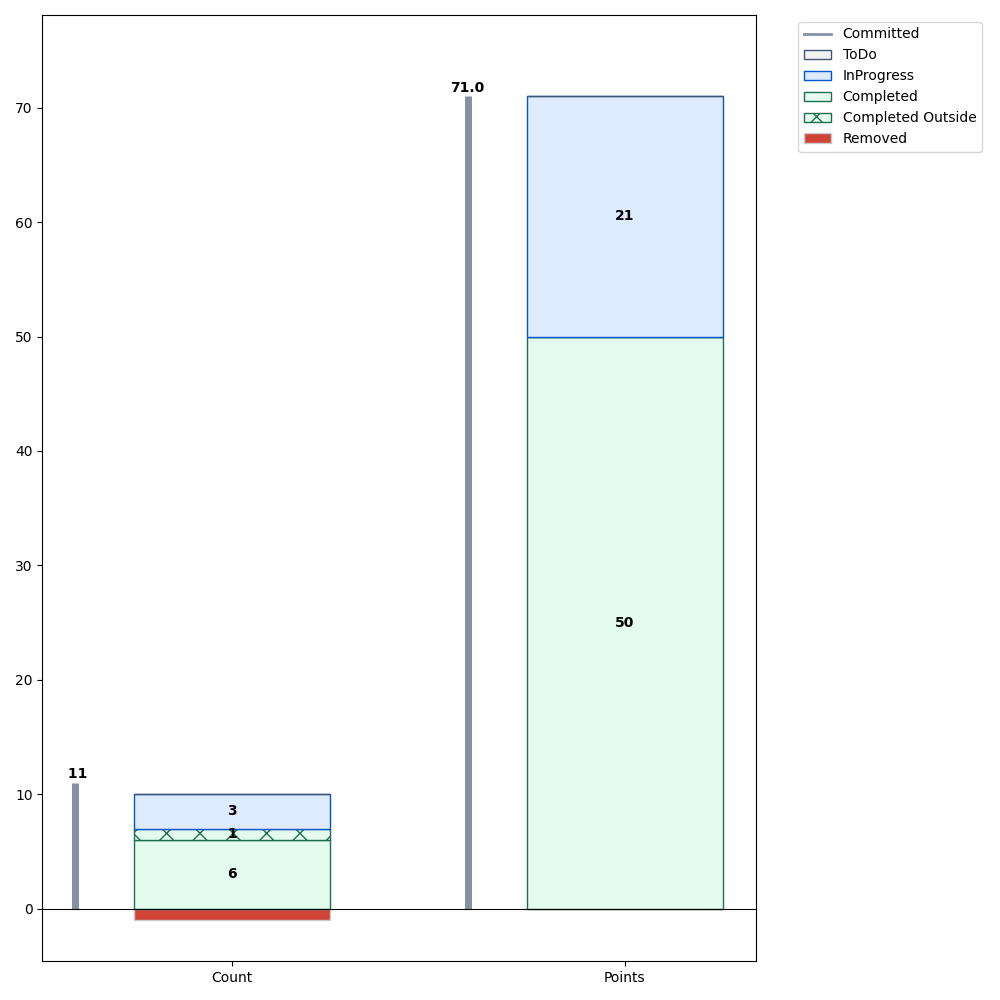

In [348]:
from IPython.display import HTML, display

html_table = login_details + sprint_details_data_table + this_sprint_predictability_data_table + committed_vs_planned_chart + committed_vs_planned_data_table + epic_statistics_table + predictability_data_table

display(HTML(html_table))
